## The program deals with orchestrator worker workflow. Orchestrator will generate sections of a topic, while workers will generate different sections based on topic.

In [37]:
from typing import TypedDict, Annotated
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from pydantic import BaseModel, Field
import operator
from langgraph.types import Send

load_dotenv()

True

In [8]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")

In [4]:
class Section(BaseModel):
    name:str = Field(description="name of the sections")
    description:str = Field(description="Brief overview of the topic and concepts of the section")

In [10]:
class Sections(BaseModel):
    sections:list[Section]=Field(description="Sections of the report")

In [9]:
structured_planner=gpt_llm.with_structured_output(Sections)

In [15]:
class orchestrator_state(TypedDict):
    topic: str
    sections:list[Section]
    complete_section: Annotated[list,operator.add]
    final_report: str

class workstate(TypedDict):
    section: Section
    complete_section : Annotated[list, operator.add]

In [17]:
def orchestrator(state: orchestrator_state) ->orchestrator_state:
    """orchestrator that generates plan for a the report on a topic provided by the user"""

    prompt= f"Generate the plan for the report. Topic for the report is {state['topic']}"
    report_sections= structured_planner.invoke(prompt)

    return {"sections":report_sections.sections}

In [21]:
def llm_call(state: workstate) -> workstate:
    """Worker writes a section of the report based on the name and descriptions"""

    prompt= f"Write a report section following the name {state['section'].name} and description {state['section'].description}"

    section=gpt_llm.invoke(prompt)

    return {"complete_section":[section.content]}



In [24]:
def assign_worker(state: orchestrator_state) -> orchestrator_state:
    """Assign a worker to each section in the plan"""

    return[Send("llm_call",{"section":s}) for s in state["sections"]]

## A synthesizer role is to combine all the response from worker nodes

In [23]:
def synthesizer(state: orchestrator_state) -> orchestrator_state:
    """Synthesize full report from the sections"""

    completed_sections =  state['complete_section']

    completed_report = "\n\n--\n\n".join(completed_sections)

    return {"final_report":completed_report}

In [25]:
graph=StateGraph(orchestrator_state)
graph.add_node("orchestrator",orchestrator)
graph.add_node("llm_call",llm_call)
graph.add_node("synthesizer",synthesizer)

graph.add_edge(START,"orchestrator")
graph.add_conditional_edges("orchestrator", assign_worker, ["llm_call"])
graph.add_edge("llm_call","synthesizer")
graph.add_edge("synthesizer",END)

In [26]:
workflow=graph.compile()

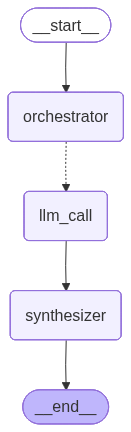

In [27]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [ ]:
result=workflow.invoke({"topic":"AI in India"})

In [36]:
Markdown(result['final_report'])



# Introduction to AI in India

Artificial Intelligence (AI) has emerged as a transformative force in the modern technological landscape. Defined broadly, AI refers to the simulation of human intelligence processes by machines, particularly computer systems. This encompasses a range of capabilities, including learning (the acquisition of information and rules for using it), reasoning (using rules to reach approximate or definite conclusions), and self-correction. As a field of study, AI intersects various disciplines, including computer science, linguistics, psychology, and neuroscience, culminating in systems that can perform tasks traditionally requiring human intellect.

Globally, AI has garnered significant attention from various sectors, including healthcare, finance, manufacturing, and transportation, due to its potential to enhance operational efficiency, personalize user experiences, and foster innovation. Major economies, particularly the United States and China, have heavily invested in AI research and development, leading to rapid advancements and widespread adoption of AI technologies. This movement has prompted countries worldwide to strategize on harnessing AI's capabilities, making it a pivotal area for economic and social development.

Within the Indian context, the relevance and growth of AI are increasingly pronounced. As one of the fastest-growing economies in the world, India has recognized AI's potential as a catalyst for socio-economic transformation. The Indian government has made significant strides in promoting AI development through initiatives like the National Strategy for Artificial Intelligence, which aims to position India as a global leader in AI by focusing on sectors where AI can drive impactful change, such as agriculture, healthcare, education, and smart cities.

India's AI ecosystem is characterized by a robust blend of government initiatives, academic research, and a vibrant startup culture. With a large pool of skilled talent and a burgeoning tech industry, the country is well-equipped to harness the benefits of AI. Initiatives like "Digital India" have further propelled the integration of AI into various aspects of daily life, from improving public services to enhancing business operations. Furthermore, Indian startups are innovating at a rapid pace in AI applications, developing solutions that cater to both local needs and global markets.

However, along with opportunities, the growth of AI in India also presents challenges, such as ethical considerations, data privacy concerns, and a need for regulatory frameworks that can keep pace with technological advancements. As the nation navigates these complexities, the importance of collaborative efforts among government, industry, and academia cannot be overstated to ensure that AI serves as a force for good, driving inclusive growth and addressing the diverse needs of the Indian population.

In conclusion, AI is not merely a technological advancement; it represents a paradigm shift in how India approaches growth and innovation. As the nation continues to invest in and develop its AI capabilities, it stands at a critical juncture, with the potential to leverage AI for comprehensive development and to assert its position on the global stage.

--

## Current State of AI Technology in India

### Overview

As of 2023, India stands as one of the most promising landscapes for artificial intelligence (AI) development and deployment. The fusion of robust technological infrastructure, a burgeoning startup ecosystem, and an extensive pool of skilled talent has positioned the country as a key player in the global AI arena. This report provides an analysis of the diverse AI technologies currently being developed and utilized across various sectors in India, including healthcare, finance, transportation, and agriculture.

### Healthcare

AI technologies in the Indian healthcare sector are revolutionizing diagnostics, patient management, and personalized treatment. Startups and established institutions are leveraging machine learning algorithms for predictive analytics, enabling early detection of diseases such as cancer and diabetes. For instance, AI-powered tools are now assisting radiologists in interpreting imaging data with remarkable accuracy, significantly reducing diagnostic time.

Telemedicine platforms harness AI to streamline patient interactions, utilizing chatbots to address common health queries and triage cases before referral to specialists. Additionally, electronic health record (EHR) systems have begun to incorporate AI to optimize patient data management, improving care coordination and outcomes.

### Finance

The Indian financial sector has rapidly adopted AI technologies to enhance risk assessment, fraud detection, and customer service. Fintech companies are deploying machine learning algorithms for real-time transaction monitoring to combat fraud, while also using predictive analytics to assess creditworthiness for personal loans. Robo-advisors, powered by AI, provide customized investment insights to consumers, making financial planning accessible to a broader audience.

Moreover, the implementation of Natural Language Processing (NLP) systems allows banks to automate customer service inquiries, leading to more efficient operations and improved customer satisfaction. Regulatory bodies have also initiated frameworks to ensure the responsible use of AI in finance, promoting transparency and accountability.

### Transportation

AI's influence on India’s transportation sector is evident through advancements in traffic management, autonomous vehicles, and logistics optimization. Smart traffic management systems utilize AI algorithms to analyze real-time traffic data, leading to improved congestion management and reduced travel times in urban areas. 

The burgeoning market for ride-hailing services employs AI-driven routing algorithms, enhancing user experience through optimized rideshare experiences. Additionally, companies are exploring the potential for autonomous vehicles in controlled environments, thus laying the groundwork for future advancements in self-driving technology.

Logistics and supply chain management are also benefitting from AI, with companies using predictive analytics to forecast demand, optimize routes, and improve inventory management. This has led to more efficient operations and a reduction in operational costs, critical for India’s rapidly growing economy.

### Agriculture

AI technologies are transforming the agriculture sector in India by promoting precision farming, pest management, and crop yield optimization. Leveraging data from sensors and drones, farmers can make informed decisions about irrigation, fertilization, and harvesting, ultimately enhancing productivity.

Machine learning models are being developed to predict weather patterns and crop diseases, enabling farmers to mitigate risks effectively. Startups are also deploying AI-driven platforms that support farmers in accessing market information, improving their bargaining power and ensuring better prices for their produce.

Furthermore, governmental initiatives are fostering the integration of AI in agriculture by promoting research and development, supporting farmer awareness programs, and providing digital infrastructure for data sharing and analysis.

### Conclusion

In conclusion, the current state of AI technology in India reflects a diverse and innovative ecosystem spanning multiple sectors. With a strong emphasis on enhancing operational efficiencies and improving service delivery, various stakeholders – including startups, established companies, and government bodies – are harnessing AI to address unique challenges faced in healthcare, finance, transportation, and agriculture. Looking ahead, continued investment in research, infrastructure, and ethical frameworks will be crucial in maximizing the benefits of AI across the Indian landscape.

--

# Government Initiatives and Policies

## Overview of Indian Government's Initiatives, Policies, and Frameworks Supporting AI Research and Application

The Indian government has recognized the transformative potential of Artificial Intelligence (AI) in driving economic growth, enhancing public services, and fostering innovation across various sectors. To harness AI's capabilities, the government has implemented several initiatives, policies, and frameworks designed to promote research, development, and application of AI technologies. A cornerstone of these efforts is the National AI Strategy, which outlines a comprehensive roadmap for integrating AI into the country's socio-economic fabric.

### National AI Strategy

Launched in 2018, the National AI Strategy aims to position India as a global leader in AI innovation while addressing challenges pertinent to its implementation. The strategy, developed by NITI Aayog (National Institute for Transforming India), emphasizes the need for a collaborative approach involving government, industry, academia, and civil society. Key objectives include:

1. **Sectoral Focus**: The strategy identifies crucial sectors such as healthcare, agriculture, education, smart cities, and mobility where AI can significantly impact. By tailoring AI solutions to the specific needs of these sectors, the government seeks to enhance productivity and improve service delivery.

2. **Research and Development**: The Indian government has been proactive in funding AI research initiatives, fostering collaboration between public and private institutions, and promoting the development of indigenous AI technologies. This includes establishing AI research centers and supporting academic institutions in their AI research endeavors.

3. **Skill Development**: Recognizing the need for a skilled workforce to support AI initiatives, the government has initiated various skill development programs aimed at equipping individuals with necessary AI competencies. Initiatives like the 'AI for All' campaign are geared towards raising awareness and enhancing skills at different educational levels.

4. **Ethics and Regulation**: The framework lays stress on ethical AI deployment, advocating for responsible and fair AI practices. The government is committed to developing guidelines to ensure AI technologies are used without bias, maintaining privacy, and safeguarding against potential misuse.

### Policy Frameworks

In addition to the National AI Strategy, several key policy frameworks and initiatives have been introduced to create a conducive ecosystem for AI development in India:

- **Digital India Programme**: This flagship initiative aims to transform India into a digitally empowered society and knowledge economy. The program supports the development of an infrastructure that facilitates AI research and application, including data accessibility and digital literacy.

- **Start-up India**: Launched in 2016, this initiative encourages innovation and entrepreneurship, particularly in the technology sector. Start-ups focusing on AI are given access to funding, mentorship, and regulatory support to help accelerate their growth and scalability.

- **Public Data Policy**: The government has initiated measures to enhance access to public datasets, ensuring that researchers and developers can access quality data for training and testing AI models, driving innovation while promoting transparency and accountability.

- **Collaborations and Partnerships**: The government has engaged in strategic partnerships with global AI leaders and organizations to facilitate knowledge exchange, best practices, and technology transfer. These collaborations aim to strengthen India’s AI capabilities and position the country as an attractive destination for AI investments.

### Conclusion

The Indian government's initiatives, including the National AI Strategy and various supporting policies, reflect a comprehensive approach to integrating AI into key sectors of the economy. By fostering research, promoting ethical standards, facilitating skill development, and encouraging collaboration, the government aims to create a thriving AI ecosystem that not only accelerates technological advancement but also ensures inclusive growth and societal benefits. As India continues to advance its AI agenda, it is poised to play a significant role in the global AI landscape while addressing local challenges and needs.

--

## Industry and Startup Ecosystem

### Landscape of AI Startups in India

The artificial intelligence (AI) startup ecosystem in India has witnessed unprecedented growth over the past decade, positioning the country as one of the leading hubs for AI innovation. As of 2023, India is home to over 2,000 AI startups, covering a diverse array of sectors, including healthcare, finance, e-commerce, agriculture, and logistics. This burgeoning ecosystem reflects a burgeoning recognition of AI's potential to drive efficiency and transformation across industries.

Founders of these AI startups often emerge from strong technical backgrounds, with many having experience in leading technology firms or research institutions. Startups like Zest AI, Razorpay, and Niramai have demonstrated a commitment to leveraging AI for impactful solutions, addressing unique challenges within their respective domains. This vibrant landscape is further enriched by an influx of talent, driven by a strong educational framework in technology and engineering, as well as India's large pool of software engineers.

### Major Players in the AI Industry

Several major players are shaping the AI landscape in India, including established tech giants, homegrown startups, and global corporations setting up research and development centers. Companies such as Infosys, Wipro, and TCS have made significant strides in integrating AI into their services, providing consultancy and deployment of AI solutions for businesses across various sectors.

In the startup realm, notable players include:

- **Fractal Analytics**: A leader in data analytics with a strong emphasis on AI-driven insights for Fortune 500 companies.

- **Niki.ai**: A conversational commerce platform that employs natural language processing to enhance customer experience.

- **SigTuple**: Utilizing machine learning and AI to automate medical diagnostics, particularly in pathology and radiology.

- **Uncanny Vision**: Specializing in AI-powered surveillance systems capable of facial recognition and anomaly detection.

These companies exemplify the innovative capabilities within India's AI sector and contribute significantly to its evolution as a global AI hub.

### Role of Venture Capital in Fostering AI Innovation

Venture capital (VC) plays a pivotal role in the growth of AI startups in India, providing not only the essential financial backing but also strategic guidance and networks that are critical for startup success. Over the past few years, the interest from VC firms in AI has surged, leading to substantial investments that have fueled the development of cutting-edge technologies.

In 2022 alone, investment in Indian AI startups reached ₹18,000 crore (approximately $2.4 billion), a significant leap from previous years, showcasing the confidence investors have in the scalability and profitability of AI solutions. Noteworthy VC firms like Sequoia Capital, Accel Partners, and Nexus Venture Partners have made substantial investments in the AI domain, bringing expertise and mentorship to nascent companies.

Moreover, government initiatives such as the Digital India program and the National AI Strategy have created a conducive environment for innovation, encouraging VCs to invest. With increasing collaboration between startups and research institutions, coupled with the backing of venture capital, India's AI ecosystem is poised for continued expansion and maturation in the global market.

In conclusion, the intersection of a vibrant startup culture, strong technical talent, major industry players, and robust venture capital support is propelling India into a significant role within the global AI landscape. As this ecosystem continues to evolve, it is set to drive not only economic growth but also long-term innovations across various industries.

--

### Challenges and Barriers to AI Adoption

The adoption of Artificial Intelligence (AI) in India presents a promising landscape for innovation and growth across sectors. However, several challenges and barriers hinder the widespread integration of AI technologies. These obstacles not only affect the implementation and scalability of AI solutions but also raise significant concerns about their ethical and societal implications. This section explores the primary challenges—data privacy, security, ethical concerns, and the digital divide—that India faces in its AI journey.

#### 1. Data Privacy

Data privacy is one of the foremost challenges in India’s AI sector. With AI systems relying heavily on vast amounts of data for training and decision-making, the management of personal information has become increasingly complex. The absence of a comprehensive data protection framework leaves individuals vulnerable to misuse of their data. While the Personal Data Protection Bill (PDPB) has been proposed to address these concerns, its implementation remains pending, creating uncertainties regarding data ownership, consent, and the rights of individuals. A lack of public awareness about data privacy further exacerbates the challenge, complicating efforts to foster trust in AI technologies.

#### 2. Security

The security of AI systems is another critical concern, as vulnerabilities can expose organizations to significant risks. Cybersecurity threats targeting AI applications can lead to data breaches, which not only undermine consumer trust but can also have severe legal implications. The increasing sophistication of cyberattacks necessitates robust security measures that are often beyond the capabilities of many businesses, especially small and medium enterprises (SMEs). Furthermore, with India being a hub for various AI startups, the lack of standardized security protocols poses additional risks, hindering the overall effectiveness and reliability of AI solutions.

#### 3. Ethical Concerns

Ethical considerations in AI deployment are paramount, particularly related to bias, accountability, and transparency. AI algorithms can inadvertently perpetuate existing biases if trained on datasets that do not adequately represent diverse populations or perspectives. This leads to unfair outcomes, particularly in critical areas such as healthcare, finance, and law enforcement. Moreover, the "black box" nature of many AI systems complicates accountability, as it may be unclear how decisions are made. Addressing these ethical challenges requires the establishment of clear guidelines and governance frameworks to ensure responsible AI development and deployment, aligning with societal values and norms.

#### 4. The Digital Divide

The digital divide presents a significant barrier to AI adoption in India. With vast disparities in access to technology and the internet, particularly between urban and rural areas, many individuals and communities are left behind in the AI revolution. This divide not only limits the potential workforce skilled in AI but also hampers the ability of diverse groups to benefit from AI-driven solutions. Bridging this gap necessitates concerted efforts from both the government and private sector to enhance digital literacy, improve infrastructure, and promote inclusive technology initiatives that empower underserved populations.

### Conclusion

Addressing these challenges is crucial for India to harness the full potential of AI technologies. Collaborative efforts among policymakers, industry stakeholders, and civil society are essential to create a conducive environment for AI adoption. Building a resilient framework that prioritizes data privacy, robust security measures, ethical transparency, and inclusivity will not only foster innovation but also ensure that the benefits of AI are equitably shared across the nation. By overcoming these challenges, India can position itself as a leader in the global AI landscape, driving sustainable growth and enhancing the quality of life for its citizens.

--

# Case Studies of Successful AI Implementations

## Introduction

As artificial intelligence (AI) continues to evolve, its applications have expanded across various sectors in India, driving innovation and transforming traditional business practices. This section highlights notable case studies that showcase the impact of AI implementations, demonstrating how organizations leverage technology to enhance efficiency, improve customer experiences, and innovate within their industries.

## 1. HDFC Bank: AI-Driven Customer Service

**Overview**: HDFC Bank, one of India's leading private sector banks, has integrated AI into its operations to enhance customer service and operational efficiency. 

**Implementation**: The bank launched an AI-powered chatbot named "Eva" (Electronic Virtual Assistant) that interacts with customers in real time to resolve queries related to banking services. Eva leverages natural language processing (NLP) to understand customer questions and deliver accurate information swiftly.

**Impact**: The implementation of Eva has significantly reduced response time for customer inquiries, handling over 4 million queries and resolving 80% of them without human intervention. This AI solution has improved customer satisfaction by providing 24/7 service availability and freeing up human agents to handle more complex requests.

## 2. Siemens: AI in Manufacturing

**Overview**: Siemens India has showcased the significant impact of AI in the manufacturing sector through its use of predictive analytics and machine learning.

**Implementation**: The company has adopted AI algorithms in its factory automation systems to predict equipment failures before they occur. By analyzing historical data and real-time sensor inputs from machinery, Siemens can forecast maintenance needs and schedule repairs proactively.

**Impact**: This predictive maintenance strategy has led to a 15% reduction in downtime and considerable cost savings. Moreover, it enhances the overall efficiency of Siemens' manufacturing processes, enabling them to maintain high-quality production standards while optimizing resource utilization.

## 3. Koo: AI for Social Media Moderation

**Overview**: Koo, an Indian microblogging platform, has integrated AI to ensure a harmonious user experience while fostering meaningful dialogue among users.

**Implementation**: The platform utilizes AI-driven content moderation tools that automatically identify and flag inappropriate content, abusive language, and misinformation. This machine learning model is continuously trained on user-generated data to improve its accuracy and effectiveness.

**Impact**: By promoting a safer online environment, Koo has grown its user base significantly, witnessing a surge in active users. Enhanced moderation practices have led to increased trust and user engagement on the platform, differentiating Koo from other social media competitors.

## 4. Niramai: AI in Healthcare

**Overview**: Niramai is a healthcare startup that uses AI for breast cancer screening through a novel thermal imaging technique.

**Implementation**: The company has developed a device that employs machine learning algorithms to analyze thermal images of the breast for early detection of tumors. This approach is non-invasive, radiation-free, and more affordable compared to traditional screening methods.

**Impact**: Niramai's AI-driven technology has the potential to significantly increase awareness and early diagnosis of breast cancer, particularly in rural and underserved areas. The startup has succeeded in reaching thousands of women, thereby contributing to their health and wellbeing, while raising awareness about breast cancer in the community.

## 5. Flipkart: AI-Powered Supply Chain Optimization

**Overview**: Flipkart, one of India's largest e-commerce platforms, has harnessed AI to streamline its supply chain and enhance customer experience.

**Implementation**: The company has developed AI algorithms that analyze consumer behavior patterns, inventory levels, and logistics data to optimize stock levels and forecast demand accurately. This AI model also helps in planning delivery routes to minimize delays.

**Impact**: The implementation of AI in supply chain management has resulted in a 20% reduction in operating costs and improved delivery times, boosting customer satisfaction. This innovation has allowed Flipkart to maintain competitiveness in the fast-paced e-commerce sector by ensuring timely deliveries and optimal resource allocation.

## Conclusion

These case studies illustrate the diverse and impactful applications of AI across different sectors in India. Organizations are not merely adopting AI technologies; they are innovating and enhancing their capabilities by leveraging data-driven insights. As the landscape of AI continues to evolve, these successful implementations serve as benchmarks for future advancements, paving the way for further innovation and transformation in the Indian economy.

--

### Future Opportunities and Growth Potential

#### Discussion on the Future of AI in India

India stands at a pivotal moment in its journey towards becoming a global leader in artificial intelligence (AI). With a burgeoning technology ecosystem, a large pool of skilled professionals, and a supportive government framework, the nation is poised to harness AI's transformative potential across various sectors. The interplay of these factors presents a plethora of opportunities for growth and innovation.

#### Opportunities for Growth and Innovation

1. **Sectoral Transformations**:
    - **Healthcare**: AI possesses the potential to revolutionize healthcare in India by enhancing diagnostics, management of medical records, and personalized treatment plans. The development of AI-driven platforms can improve accessibility to quality healthcare services, especially in rural and underserved areas.
    - **Agriculture**: AI can optimize agricultural practices through predictive analytics, resource management, and precision farming techniques. Smart farming solutions can lead to increased yields, reduced wastage, and enhanced sustainability.
    - **Finance**: The fintech landscape in India is rapidly evolving, with AI facilitating fraud detection, risk assessment, and personalized customer experiences. Leveraging AI in banking and finance can significantly improve operational efficiency and customer satisfaction.

2. **Start-up Ecosystem**:
    - India's vibrant start-up ecosystem, particularly in AI and machine learning, is a hotbed for innovation. With access to venture capital and a growing number of incubators and accelerators, Indian startups can drive breakthroughs in AI applications across diverse sectors, establishing themselves as pivotal players in the global market.

3. **Education and Workforce Development**:
    - As AI technologies proliferate, there is an increasing demand for skilled professionals. India can capitalize on this opportunity by enhancing its education system through AI-focused curricula, vocational training programs, and collaborative research initiatives between academia and industry. Upskilling the workforce will not only meet domestic needs but also cater to global demand for AI expertise.

4. **Government Initiatives**:
    - The Indian government has recognized AI's potential as a catalyst for growth and innovation. Initiatives such as the National AI Strategy and the establishment of research centers focused on AI and data science provide a framework for strategic investment and development in the AI sector. Continued government support for innovation and infrastructure development can bolster India's position in the global AI landscape.

#### Potential for Global Leadership in AI Technology

India's unique blend of talent, demographic dividend, and technological infrastructure positions it as a potential leader in the global AI arena. The following factors contribute to this potential:

- **Diverse Data Sources**: India’s diverse population and varying socio-economic contexts generate rich data sets, essential for training robust AI models. This data diversity can lead to more inclusive AI solutions that address the needs of a broad spectrum of populations.

- **International Collaborations**: By fostering partnerships with leading global tech companies and research institutions, India can accelerate its AI capabilities. Collaborations in research, development, and deployment of AI technologies can enhance innovation and ensure that India remains at the forefront of AI advancements.

- **Ethical AI Development**: As the global conversation around the ethical implications of AI grows, India has the opportunity to lead the way in developing responsible and ethical AI frameworks. Establishing standards and regulations that prioritize ethical considerations can position India as a thought leader in the global AI discourse.

In conclusion, the future of AI in India is brimming with opportunities for growth and innovation. By leveraging its unique strengths, fostering a supportive ecosystem, and prioritizing ethical considerations, India can emerge as a formidable player on the global AI stage, contributing not only to technological advancement but also to socio-economic development. The actions taken today will determine India's trajectory as a leader in AI technology, with significant implications for the future of industries, economies, and societies worldwide.

--

### Conclusion

In recent years, the development of Artificial Intelligence (AI) has emerged as a cornerstone for technological advancement and economic growth globally, with India positioning itself as a key player in this transformative field. This report has highlighted several key findings that underscore the potential of AI in driving innovation, improving efficiency, and addressing pressing societal challenges in India.

**Key Findings:**

1. **Economic Potential:** AI has the capacity to contribute significantly to India's GDP, projected to reach USD 957 billion by 2035, primarily through enhancements in productivity and the creation of new market opportunities across various sectors such as healthcare, agriculture, and manufacturing.

2. **Talent Development:** India boasts a large pool of technical talent, with numerous educational institutions and research organizations focusing on AI. However, there remains a gap in specialized training and real-world experience that needs to be bridged to maximize this potential.

3. **Government Initiatives:** The Indian government has launched various initiatives, such as the National AI Strategy and the establishment of AI research centers, aimed at fostering a supportive ecosystem for AI development. These efforts are crucial for maintaining momentum and aligning public policy with technological advancements.

4. **Ethical Considerations:** As AI technologies evolve, addressing ethical concerns surrounding data privacy, algorithmic bias, and accountability will be paramount to ensure responsible AI deployment and build public trust.

5. **Industry Collaboration:** There is a growing trend of collaboration between startups, established enterprises, and academia, which is essential for driving innovation and translating research into market-ready solutions.

**Recommendations for Stakeholders:**

1. **Strengthen Educational Programs:** Stakeholders should invest in curriculum development that emphasizes AI, data science, and machine learning, ensuring that graduates possess the necessary skills to meet industry demands. Public-private partnerships can facilitate internships and hands-on learning experiences.

2. **Foster Research and Innovation Hubs:** The establishment of AI innovation hubs and incubators can facilitate collaboration among startups, researchers, and industry leaders, accelerating the development of novel applications and solutions tailored to India’s unique challenges.

3. **Enhance Policy Frameworks:** Policymakers should continually adapt regulations to stimulate AI growth, prioritizing frameworks that encourage innovation while addressing ethical concerns. This includes standards for data protection, privacy regulations, and guidelines for algorithmic transparency.

4. **Promote Public Awareness:** Increasing awareness about the benefits and challenges of AI through public campaigns can help demystify the technology and garner broader support for its integration across various sectors.

5. **Encourage International Collaboration:** Engaging with global AI communities and participating in international research initiatives can provide Indian stakeholders with access to best practices, advanced technologies, and funding opportunities, ultimately enhancing India’s position in the global AI landscape.

In conclusion, the future of AI development in India holds transformative promise. By focusing on education, research, ethical standards, collaboration, and policy frameworks, stakeholders can harness the full potential of AI to drive inclusive growth and innovation in India.